# Point-Cloud to Minecraft

by James Gopsill

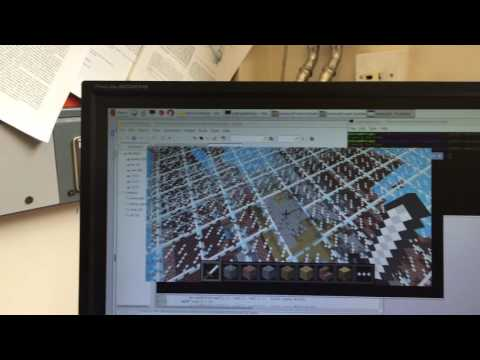

In [1]:
from IPython.display import YouTubeVideo
YouTubeVideo("fS8cVxznAEo")

<hr>

This notebook provides a brief example of how to discretise a PLY point-cloud data into blocks that can be represented in minecraft. The point-cloud data has been generated by a Googles Project Tango device. The work is part of the [PhysiCAD](http://physicad.com/) research project looking at tangible interfaces for designing new products.

## Step 1: Discretising PlyData

The first step involves discretising the 3D space into bins that will form the blocks in minecraft. To do this, we need to have the plyfile and numpy packages installed.

[1]: [http://physicad.com/]

In [2]:
from plyfile import PlyData, PlyElement
import numpy as np

Once we have imported these packages, we can load the data from the PLY file that has been generated from the Project Tango device. We then extract all the vertices from the imported data and take the x, y and z co-ordinates.

In [ ]:
# Read in the ply data (be aware, this my take some time to load up)
plydata = PlyData.read('room.ply')

vertices = []

for vertex in plydata['vertex']:
    vertices.append([vertex[0], vertex[1], vertex[2]])

# Transform list into a numpy array
vertices = np.asarray(vertices)

print('Number of rows & cols:', vertices.shape)
print('Point-Cloud Summary')
print('X Min:', np.min(vertices[:,0]), 'X Max:', np.max(vertices[:,0]))
print('Y Min:', np.min(vertices[:,1]), 'Y Max:', np.max(vertices[:,1]))
print('Z Min:', np.min(vertices[:,2]), 'Z Max:', np.max(vertices[:,2]))

Now we have all the points within a numpy array, we set-up the discretised 3-dimensional space. To do this, we set a width that each box will be and in this case, the width will be the same for all axes. Using this width, we can create a range of values that represent the start and end boundaries for each box in the 3-axes (i.e. 0, 0.3, 0.6, 0.8...). We make the range so that it covers the entire point-cloud space.

In [ ]:
# Set the width of the boxes in the 3D space
box_width = 0.03

# The box increments in the x direction
x_range = np.arange(np.min(vertices[:,0]) - box_width, np.max(vertices[:,0]) + box_width, box_width)
# The box increments in the y direction
y_range = np.arange(np.min(vertices[:,1]) - box_width, np.max(vertices[:,1]) + box_width, box_width)
# The box increments in the z direction
z_range = np.arange(np.min(vertices[:,2]) - box_width, np.max(vertices[:,2]) + box_width, box_width)

Using this discretised space, we can generate a 3-dimesional histogram where the number of points within each box are counted. Luckily, numpy has a function that can do this for us.

In [ ]:
# Calculating 3d histogram
H, edges = np.histogramdd(vertices, bins=[x_range, y_range, z_range])

print('Bin Shape:', H.shape)
print('Number of Points in the Bins:', np.sum(H))

From this, we have a set of bin co-orindates and the respective number of points within that bin. To reduce the size of the file we will store, all we need to include are the bins that have points within them. Therefore, this next part iterates through all the bins from the histogram and if the bin contains a point, the location and number of points are appended to a list.

The resulting list is then converted into an array of integers that are then saved to a csv file. This will be the file that we will use to decide where the blocks will be placed in Minecraft.

In [ ]:
# Get the bins with values and save them as a csv for minecraft to build from
minecraft_boxes = []
# get the lengths of the 3-dimensions of H
x_bins, y_bins, z_bins = H.shape
# Loop through all the bins
for i in range(0, x_bins):
    for j in range(0, y_bins):
        for k in range(0, z_bins):
            # If the bin contains a point from the point-cloud add it as a possible minecraft block
            if (H[i,j,k] > 0):
                # in minecraft, we will use indices to declare the positions of the blocks
                minecraft_boxes.append([ i, j, k, H[i,j,k] ])

# turn list into a numpy array
minecraft_boxes = np.asarray(minecraft_boxes)
print(minecraft_boxes.shape)
# save array as integers in comma separated variable format
np.savetxt('room-blocks.csv', minecraft_boxes.astype(int), delimiter=',', fmt='%i')

## Step 2: Load into Minecraft Pi

Step 2 takes the block data we have generated from Step 1 and creates a world in minecraft. For this code to work, it must be running on a Raspberry Pi as the pi contains a python package that can interface with Minecraft Pi.

In [ ]:
from mcpi.minecraft import Minecraft
import mcpi.block as block_types
import numpy as np

Once we have imported the necessary packages, we need to load minecraft up and start/load a world. When this has loaded up, you can tab out and go back and run your python code. Any manipulations to the world will be performed to the currently loaded one.

For our case, we first create hook to our Minecraft world and post 'Hello World' to chat. You should see this appear on you Minecraft screen. We then take the centre of the world and create a solid stone floor of 200 x 200 and remove any blocks that may be above it.

In [ ]:
# Create hook into minecraft
mc = Minecraft.create()
# Post to chat to check
mc.postToChat('Hello World')

# Using the center of the world as our anchor for the room
x = 0
y = 0
z = 0

# Creating the flat plate (centred around x, y, z)
print("Creating the floor")
mc.setBlocks(x-100, y-1, z-100, x+100, y-1, z+100,  block_types.STONE)

# Remove all blocks above the floor
mc.setBlocks(x-100, y, z-100, x+100, y+100, z+100,  block_types.AIR)

No we load up our blocks that we have stored as a csv and iterate through each one. In this case, if the number of points exceeds 5, we place the block into the Minecraft world. We initially set all the blocks to stone and found it very difficult to identify objects within the world. To combat this, we set different block types for blocks at certain heights within the space. For example, we set anything above 30 as glass to represent the ceiling and using glass also allows the lighting from the world to enter the room.

In [ ]:
# Build Structure
# load the boxes from csv
boxes = np.genfromtxt('room.csv', delimiter=',')
# get the number of rows and columns
num_rows, num_cols = boxes.shape
# iterate through each row
for i in range(0, num_rows):
    row = boxes[i]
    if row[3] > 5:
        # We are going to use block types to achieve a sense of height and separation of elements within the room
        # if z is greater the 30, we will consider it the ceiling and set it to glass to let the light in from the minecraft world
        if row[2] > 30:
            mc.setBlock(row[0]-25, row[2], row[1]-25,  block_types.GLASS)
        # Anything between 203 and 30 will be brick and most likely be the wallss
        elif row[2] > 20:
            mc.setBlock(row[0]-25, row[2], row[1]-25,  block_types.BRICK_BLOCK)
        # Below 8 we will class oas the floor
        elif row[2] < 8:    
            mc.setBlock(row[0]-25, row[2], row[1]-25,  block_types.WOOD_PLANKS)
        # Everything else can be stone
        else:
            mc.setBlock(row[0]-25, row[2], row[1]-25,  block_types.STONE_SLAB_DOUBLE)

## Results

Below are the results from this demo with the video showing the creation of the world as it is reading in the data from the csv. The images show some close ups of some of the features in the room.

### Video

In [ ]:
from IPython.display import YouTubeVideo
YouTubeVideo("fS8cVxznAEo")

### Images

![alt text](File_000.jpeg "Results 1")

![alt text](File_001.jpeg "Results 2")

![alt text](File_002.jpeg "Results 3")

![alt text](File_003.jpeg "Results 4")

![alt text](File_004.jpeg "Results 5")